### Youtube Analysis

In [1]:
# import libraries 
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srushtikamble/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/srushtikamble/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
api_key = ' ' #mention the api key

In [4]:
channel_id = ['UCpqXJOEqGS-TCnazcHCo0rA']

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey =api_key)

In [6]:
# create a function for getting the stats 
def get_channel_stats(youtube, channel_id):
    all_data =[]
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_id)
    )
    response = request.execute()
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
               'subscribers': item['statistics']['subscriberCount'],
               'views': item['statistics']['viewCount'],
               'totalVideos': item['statistics']['videoCount'],
               'playlist': item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)


    return(pd.DataFrame(all_data))

In [7]:
channel_stats =get_channel_stats(youtube, channel_id)

In [8]:
channel_stats

,channelName,subscribers,views,totalVideos,playlist
0,theRadBrad,13400000,6144107122,8375,UUpqXJOEqGS-TCnazcHCo0rA


In [9]:
playlist_id = "UUpqXJOEqGS-TCnazcHCo0rA"

# function to get video ids in the playlist
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken') 
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
    return video_ids    


In [10]:
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

8312

In [12]:
# function to get video details of the video ids
def get_video_details(youtube, video_ids):
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id= ','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description','tags','publishesAt'],
                            'statistics': ['viewCount','likeCount','favouriteCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption']}
            video_info = {}
            video_info['video_id'] = video['id']
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)  
    return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube, video_ids)
video_df.head()

,video_id,channelTitle,title,description,tags,publishesAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,HSKPv1Iu6pQ,theRadBrad,ALAN WAKE 2 PS5 Walkthrough Gameplay Part 9 - ...,PS5 Alan Wake 2 Walkthrough Gameplay Part 9 in...,"[Alan Wake 2, Alan Wake 2 Gameplay, Alan Wake ...",None,6704,814,None,51,PT1H27M42S,hd,false
1,9iS-XTeg3Lo,theRadBrad,I FOUND A PORTAL TO THE SPIDER-VERSE in SPIDER...,PS5 Spider-Man 2 (Marvel's Spider-Man 2) Walkt...,"[Spiderman 2, Spider-Man 2, Marvel's Spider-Ma...",None,103156,4943,None,219,PT53M3S,hd,false
2,tCfFLhHcOyg,theRadBrad,ALAN WAKE 2 PS5 Walkthrough Gameplay Part 8 - ...,PS5 Alan Wake 2 Walkthrough Gameplay Part 8 in...,"[Alan Wake 2, Alan Wake 2 Gameplay, Alan Wake ...",None,69045,3025,None,186,PT1H11M46S,hd,false
3,ouI_fZIC4w0,theRadBrad,MILES MORALES VS MYSTERIO BOSS in SPIDER-MAN 2...,PS5 Spider-Man 2 (Marvel's Spider-Man 2) Walkt...,"[Spiderman 2, Spider-Man 2, Marvel's Spider-Ma...",None,90966,4285,None,194,PT1H20S,hd,false
4,QMuqcqpXPmg,theRadBrad,CALL OF DUTY MODERN WARFARE 3 ENDING - PS5 Wal...,PS5 Call of Duty Modern Warfare 3 2023 Campaig...,"[Call of Duty Modern Warfare 3 Campaign, Call ...",None,154188,8887,None,576,PT28M2S,hd,false


In [14]:
# function to get video comments 
def get_comments_in_videos(youtube, video_ids):
    all_comments = []

    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)

        except: 
            # When error occurs - most likely because comments are disabled on a video
            pass
        else:
            all_comments.append(comments_in_video_info)


    return pd.DataFrame(all_comments)     

In [15]:
comments_df = pd.DataFrame()
comments_df= get_comments_in_videos(youtube, video_ids)
comments_df

,video_id,comments
0,HSKPv1Iu6pQ,[BRAD PLEASE LOOK TO YOUR LEFT GOING DOEN THOS...
1,HSKPv1Iu6pQ,[BRAD PLEASE LOOK TO YOUR LEFT GOING DOEN THOS...
2,9iS-XTeg3Lo,[Thanks for all the support fam. I’m feeling b...
3,9iS-XTeg3Lo,[Thanks for all the support fam. I’m feeling b...
4,tCfFLhHcOyg,[Appreciate your support on this so far! Means...
...,...,...
8643,iNGeEaCUXsU,[Oh yeh i know that youtuber you should met ca...
8644,5-uovKr-Vso,[Thats it! I'm buyin' it!\nThanks Brad!!\nYou'...
8645,5-uovKr-Vso,[Thats it! I'm buyin' it!\nThanks Brad!!\nYou'...
8646,ZnqMoXlNoM8,"[The even yell three crown coach gun, How did ..."


Data cleaning on the comments dataframe

In [29]:
comments_df.isnull().sum()

video_id    0
comments    0
dtype: int64

In [30]:
comments_df['comments'] = comments_df['comments'].astype(str)

In [31]:
print(comments_df.dtypes)

video_id    object
comments    object
dtype: object


In [16]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 12.9 MB/s eta 0:00:00a 0:00:01


In [17]:
# Perform sentiment analysis using TextBlob
from textblob import TextBlob

In [32]:
# function to represent every comment as positive or negative
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [33]:
# Apply sentiment analysis to comments column
comments_df['sentiment'] = comments_df['comments'].apply(get_sentiment)

In [34]:
print(comments_df)

         video_id                                           comments  \
0     HSKPv1Iu6pQ  ['BRAD PLEASE LOOK TO YOUR LEFT GOING DOEN THO...   
1     HSKPv1Iu6pQ  ['BRAD PLEASE LOOK TO YOUR LEFT GOING DOEN THO...   
2     9iS-XTeg3Lo  ['Thanks for all the support fam. I’m feeling ...   
3     9iS-XTeg3Lo  ['Thanks for all the support fam. I’m feeling ...   
4     tCfFLhHcOyg  ['Appreciate your support on this so far! Mean...   
...           ...                                                ...   
8643  iNGeEaCUXsU  ["Oh yeh i know that youtuber you should met c...   
8644  5-uovKr-Vso  ["Thats it! I'm buyin' it!\nThanks Brad!!\nYou...   
8645  5-uovKr-Vso  ["Thats it! I'm buyin' it!\nThanks Brad!!\nYou...   
8646  ZnqMoXlNoM8  ['The even yell three crown coach gun', 'How d...   
8647  ZnqMoXlNoM8  ['The even yell three crown coach gun', 'How d...   

      sentiment  
0      0.148335  
1      0.148335  
2      0.117702  
3      0.117702  
4      0.216783  
...         ...  
8643   0.

In [36]:
print(comments_df['sentiment'].describe())

count    8648.000000
mean        0.100369
std         0.127110
min        -0.700000
25%         0.020001
50%         0.101055
75%         0.180562
max         0.660000
Name: sentiment, dtype: float64


## Data Cleaning 

In [37]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishesAt        True
viewCount         False
likeCount          True
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [38]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishesAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [39]:
# convert into numerical values
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols]= video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [ ]:
pip install isodate

In [40]:
import isodate
video_df['duration_sec'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['duration_sec'] = video_df['duration'].astype('timedelta64[s]')
video_df[['duration_sec', 'duration']]

,duration_sec,duration
0,0 days 01:27:42,PT1H27M42S
1,0 days 00:53:03,PT53M3S
2,0 days 01:11:46,PT1H11M46S
3,0 days 01:00:20,PT1H20S
4,0 days 00:28:02,PT28M2S
...,...,...
8307,0 days 00:07:49,PT7M49S
8308,0 days 00:03:50,PT3M50S
8309,0 days 00:05:30,PT5M30S
8310,0 days 00:02:13,PT2M13S


In [41]:
# total number of tags 
video_df['tagCount']=video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [42]:
video_df

,video_id,channelTitle,title,description,tags,publishesAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,duration_sec,tagCount
0,HSKPv1Iu6pQ,theRadBrad,ALAN WAKE 2 PS5 Walkthrough Gameplay Part 9 - ...,PS5 Alan Wake 2 Walkthrough Gameplay Part 9 in...,"[Alan Wake 2, Alan Wake 2 Gameplay, Alan Wake ...",None,6704.0,814.0,NaN,51.0,PT1H27M42S,hd,false,0 days 01:27:42,24
1,9iS-XTeg3Lo,theRadBrad,I FOUND A PORTAL TO THE SPIDER-VERSE in SPIDER...,PS5 Spider-Man 2 (Marvel's Spider-Man 2) Walkt...,"[Spiderman 2, Spider-Man 2, Marvel's Spider-Ma...",None,103156.0,4943.0,NaN,219.0,PT53M3S,hd,false,0 days 00:53:03,22
2,tCfFLhHcOyg,theRadBrad,ALAN WAKE 2 PS5 Walkthrough Gameplay Part 8 - ...,PS5 Alan Wake 2 Walkthrough Gameplay Part 8 in...,"[Alan Wake 2, Alan Wake 2 Gameplay, Alan Wake ...",None,69045.0,3025.0,NaN,186.0,PT1H11M46S,hd,false,0 days 01:11:46,24
3,ouI_fZIC4w0,theRadBrad,MILES MORALES VS MYSTERIO BOSS in SPIDER-MAN 2...,PS5 Spider-Man 2 (Marvel's Spider-Man 2) Walkt...,"[Spiderman 2, Spider-Man 2, Marvel's Spider-Ma...",None,90966.0,4285.0,NaN,194.0,PT1H20S,hd,false,0 days 01:00:20,22
4,QMuqcqpXPmg,theRadBrad,CALL OF DUTY MODERN WARFARE 3 ENDING - PS5 Wal...,PS5 Call of Duty Modern Warfare 3 2023 Campaig...,"[Call of Duty Modern Warfare 3 Campaign, Call ...",None,154188.0,8887.0,NaN,576.0,PT28M2S,hd,false,0 days 00:28:02,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,cjeVjNPDuJk,theRadBrad,Damaj's Nuke on Salvage (Commentary by theRadB...,Check out my channel at: http://www.youtube.c...,"[Call of Duty, Modern Warfare 2, Call of Duty ...",None,16422.0,564.0,NaN,52.0,PT7M49S,hd,false,0 days 00:07:49,33
8308,JkIcx6gjb3g,theRadBrad,theRadBrad's Tar-21 TDM on Rust (MW2 Gameplay/...,Check out my channel at: http://www.youtube.co...,"[Modern Warfare 2, Call of Duty, Call of Duty ...",None,20910.0,709.0,NaN,59.0,PT3M50S,hd,false,0 days 00:03:50,31
8309,KP4SXSJQXNY,theRadBrad,Modern Warfare 2: theRadBrad's Tar-21 Flawless...,Check out my channel at: http://www.youtube.co...,"[Modern Warfare 2, Call of Duty, Call of Duty ...",None,41828.0,919.0,NaN,89.0,PT5M30S,hd,false,0 days 00:05:30,33
8310,Ye9lTlCx7As,theRadBrad,Modern Warfare 2: theRadBrad's Random Clips,Check out my channel at: http://www.youtube.co...,"[theRadBrad, RadBrad, Modern Warfare 2, MW2, G...",None,30150.0,928.0,NaN,87.0,PT2M13S,hd,false,0 days 00:02:13,29


In [43]:
video_df['title'].sort_values(ascending=False)[:9]

8308    theRadBrad's Tar-21 TDM on Rust (MW2 Gameplay/...
8055    theRadBrad's Let's Play Montage | Edited by Wi...
8231    theRadBrad and xRags :: 50 - 1 :: Halo Reach A...
3247                               theRadBrad Live Stream
4723    inFamous First Light Walkthrough Gameplay Part...
4724    inFamous First Light Walkthrough Gameplay Part...
4725    inFamous First Light Walkthrough Gameplay Part...
4727    inFamous First Light Walkthrough Gameplay Part...
4728    inFamous First Light Walkthrough Gameplay Part...
Name: title, dtype: object

## EDA

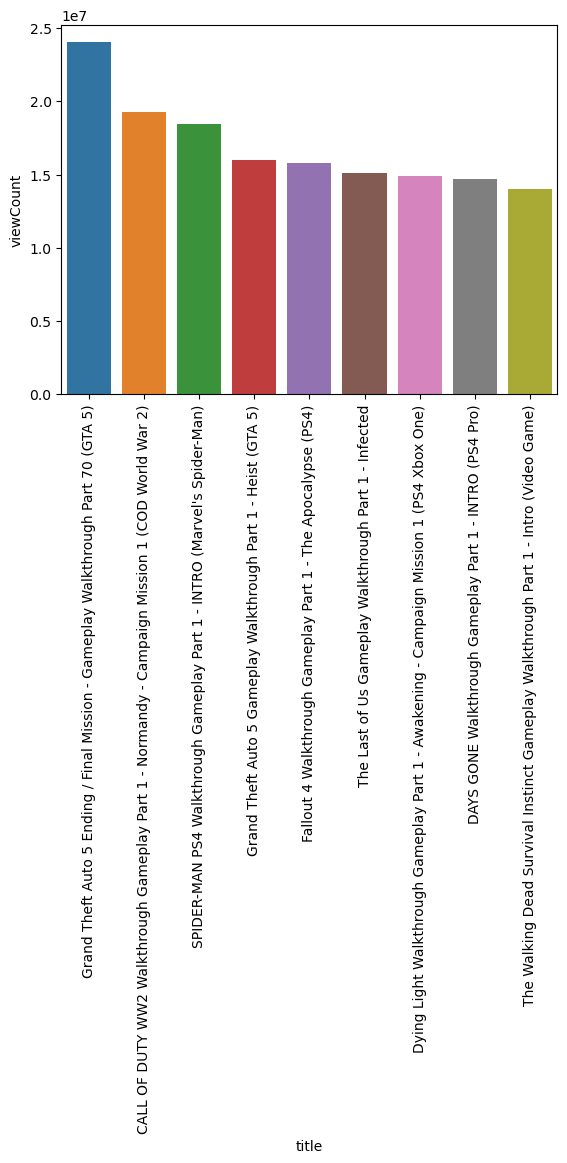

In [44]:
ax= sns.barplot(x = 'title', y='viewCount', data= video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

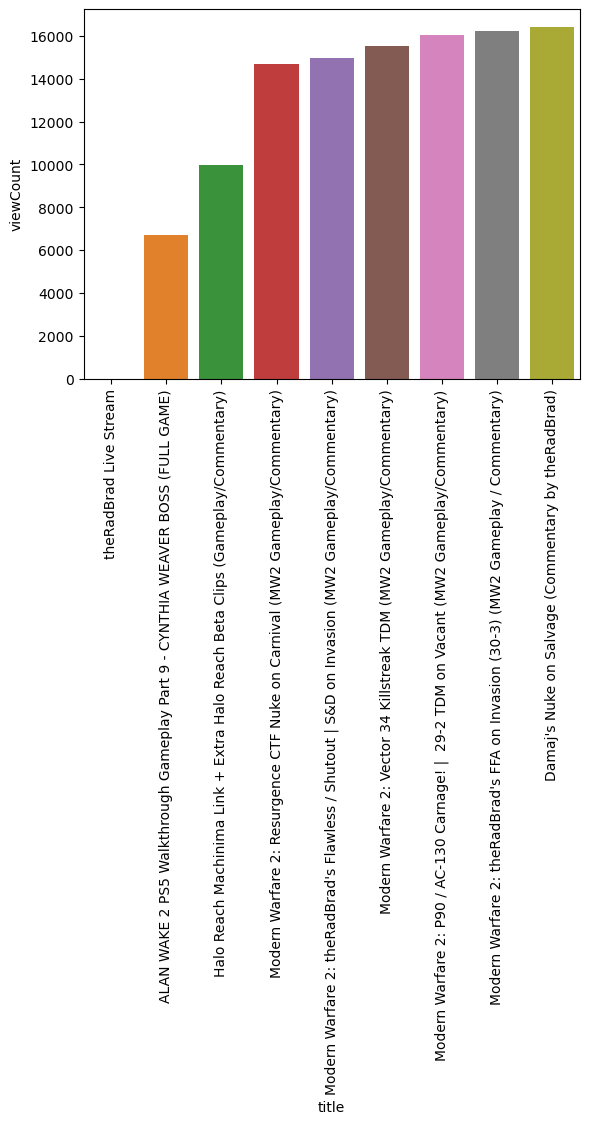

In [45]:
ax= sns.barplot(x = 'title', y='viewCount', data= video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<Axes: xlabel='channelTitle', ylabel='viewCount'>

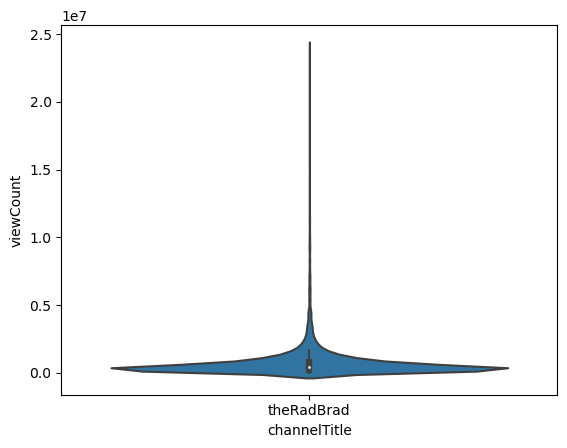

In [46]:
sns.violinplot(data=video_df,x='channelTitle', y='viewCount')

<Axes: xlabel='viewCount', ylabel='channelTitle'>

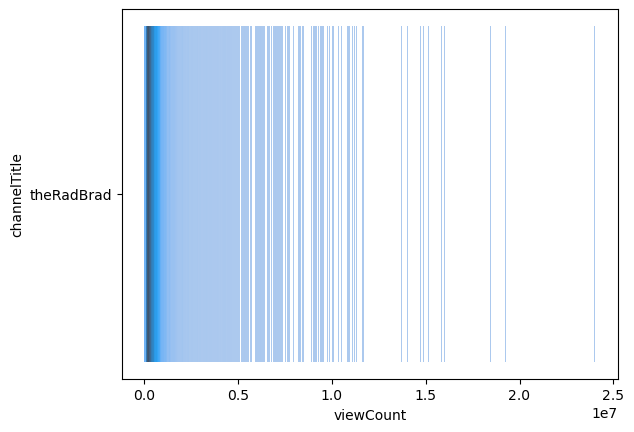

In [47]:
sns.histplot(data=video_df,y='channelTitle', x='viewCount')

<Axes: xlabel='likeCount', ylabel='viewCount'>

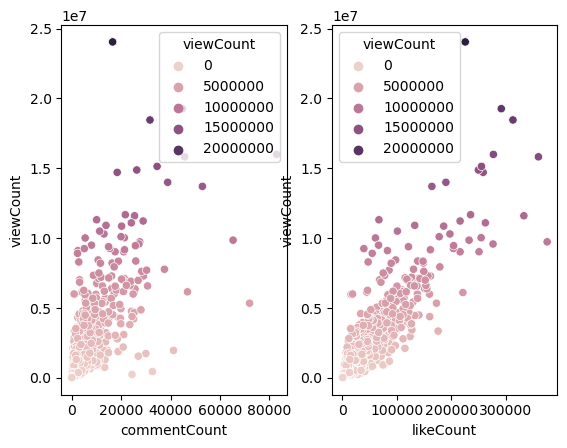

In [48]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data=video_df, x= 'commentCount', y='viewCount', ax= ax[0],hue='viewCount')
sns.scatterplot(data=video_df, x= 'likeCount', y='viewCount', ax= ax[1],hue='viewCount')

<Axes: xlabel='duration_sec', ylabel='Count'>

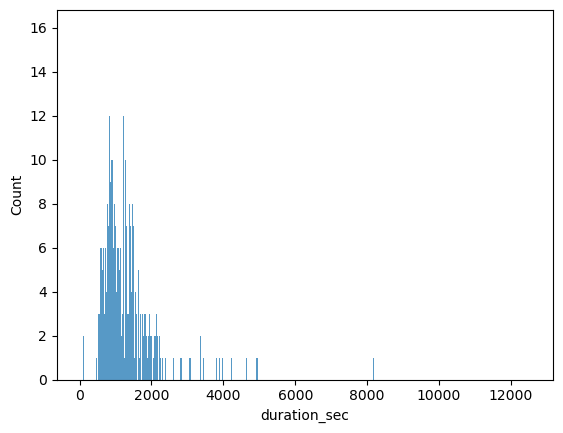

In [49]:
sns.histplot(data= video_df, x='duration_sec', bins=10)

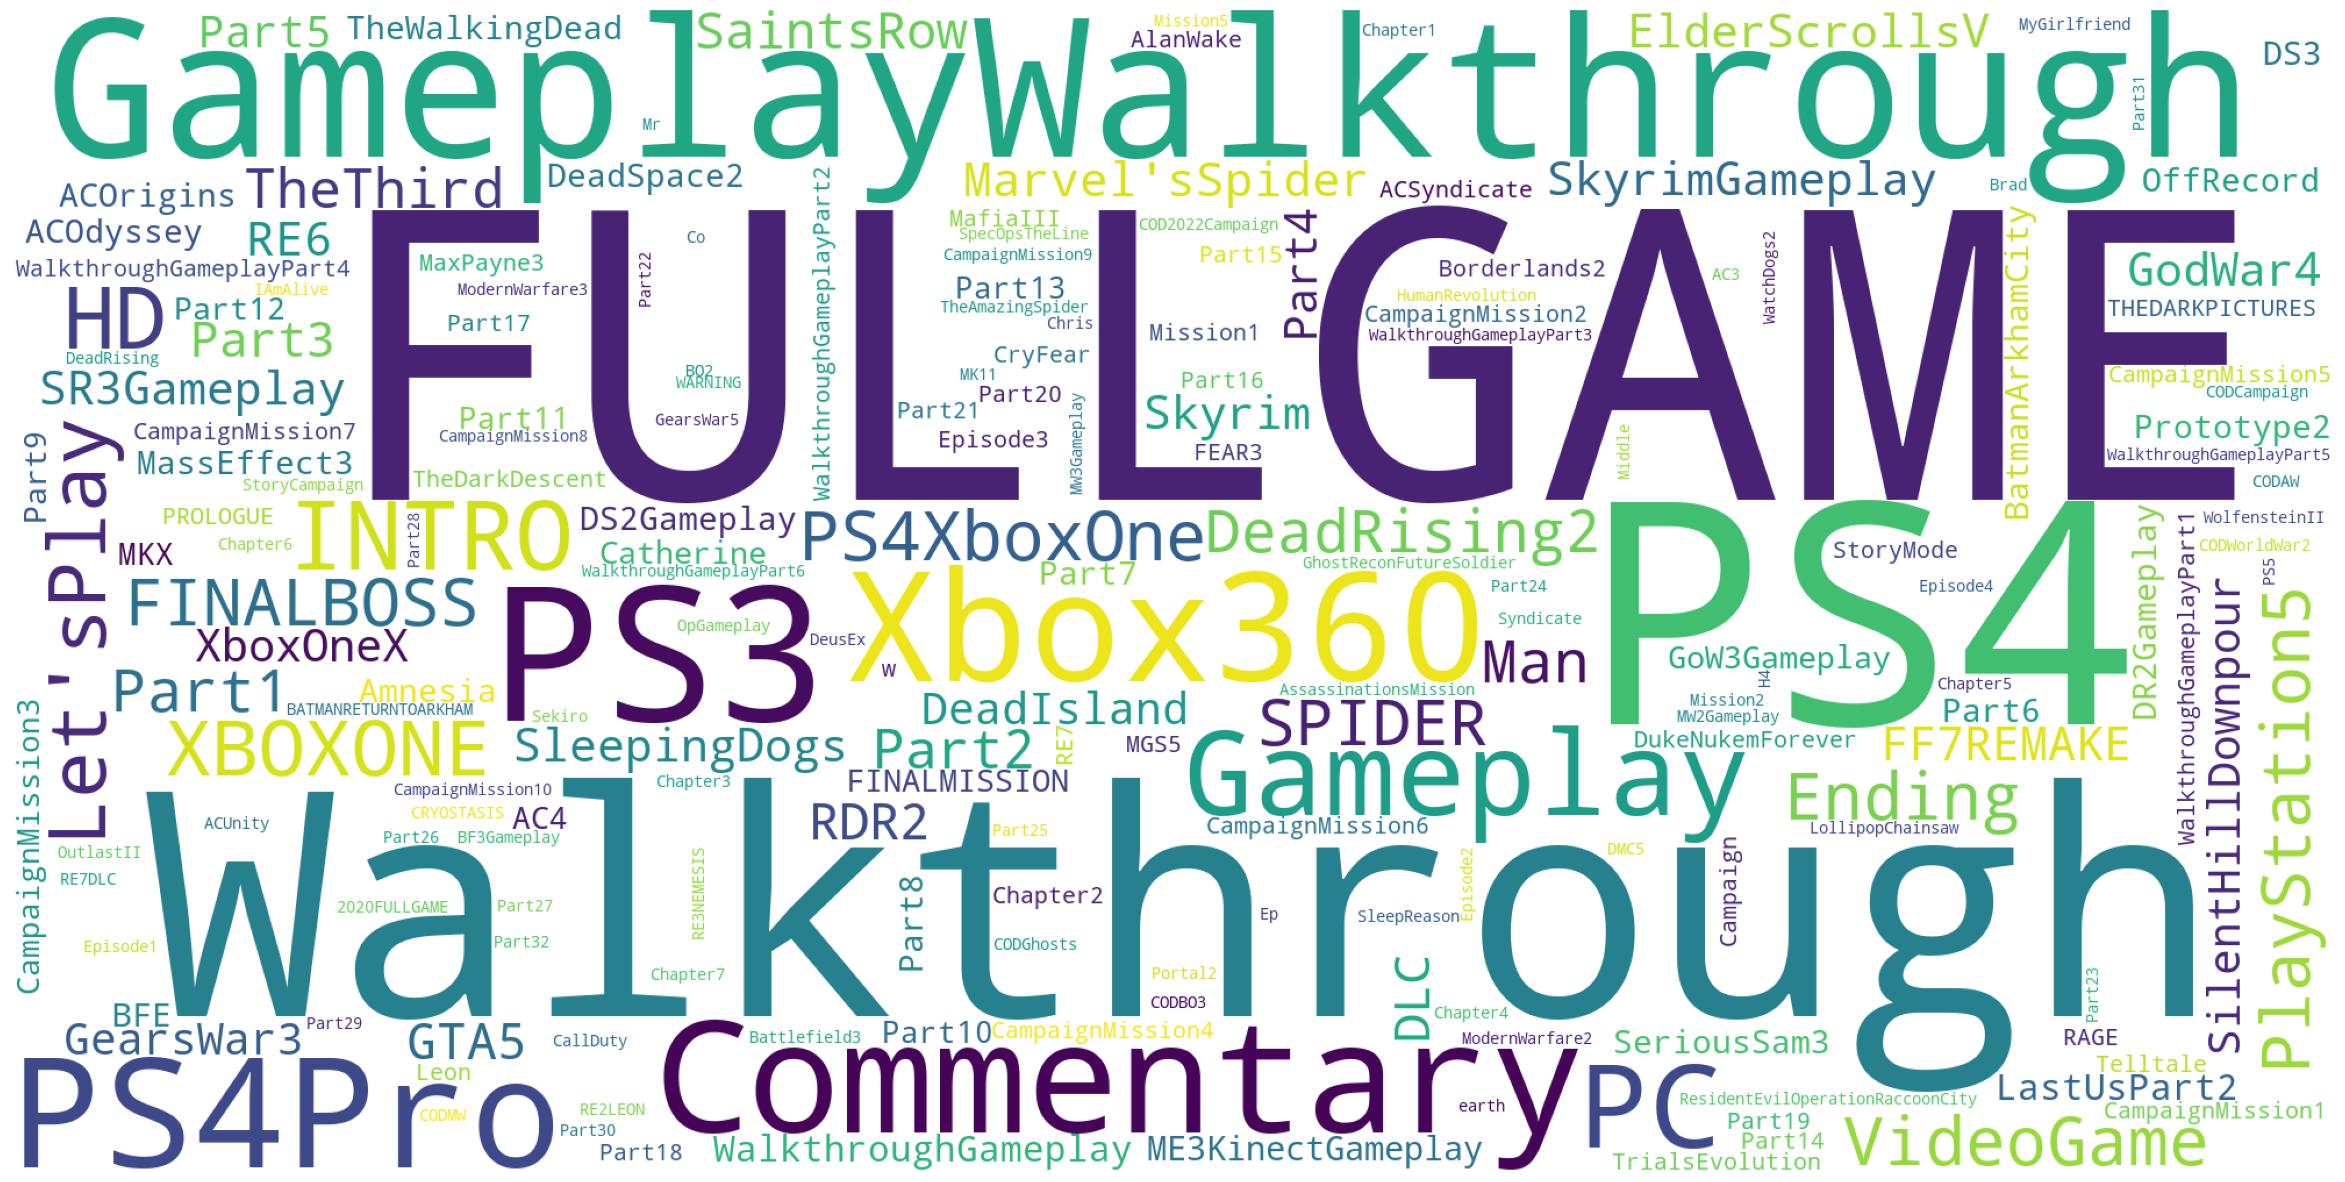

In [50]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ''.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off');
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='white',
                     colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

<Axes: xlabel='tagCount', ylabel='viewCount'>

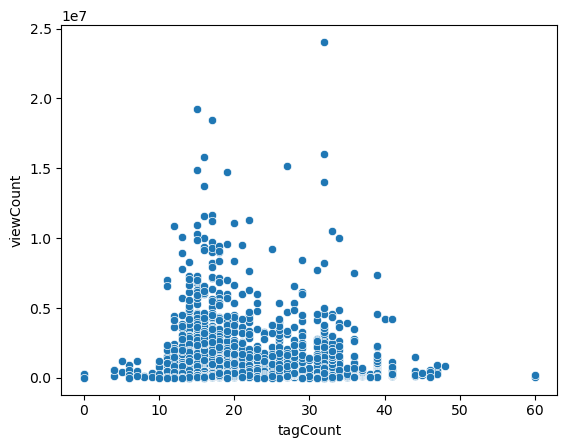

In [51]:
sns.scatterplot(data = video_df, x= 'tagCount', y='viewCount')

## Sentiment Analysis

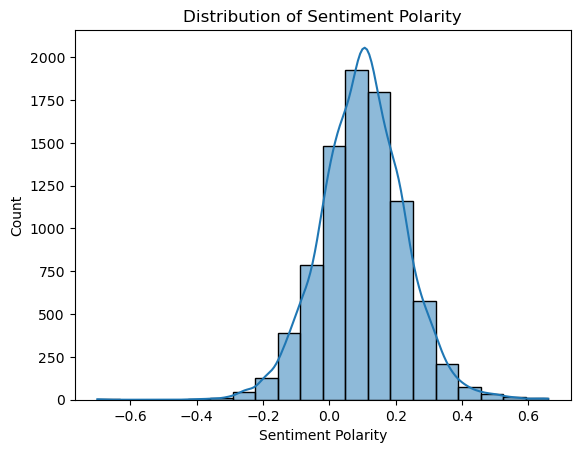

In [52]:
sns.histplot(comments_df['sentiment'], bins=20, kde=True)
plt.xlabel('Sentiment Polarity')
plt.title('Distribution of Sentiment Polarity')
plt.show()

In [53]:
# Grouping by video_id and getting mean sentiment
mean_sentiment_per_video = comments_df.groupby('video_id')['sentiment'].mean()
print(mean_sentiment_per_video)

video_id
--ewARVZRc0    0.097304
-11SfwtOyME    0.224134
-1rJ1RhH2nc    0.131944
-2q-ZpganBM    0.051786
-45-a46KGgE    0.237917
                 ...   
zwNziJZP50w    0.202206
zwpoegHs9sE    0.098529
zzIzXaYUcc0    0.058750
zztCJcT8fG0    0.298139
zzz7rrVDVeU    0.158333
Name: sentiment, Length: 4324, dtype: float64


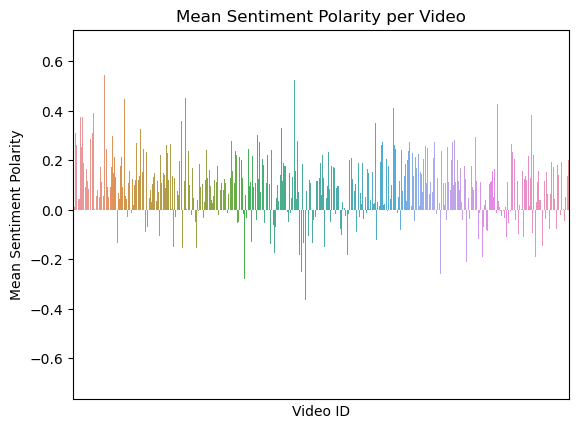

In [59]:
# Visualize sentiment per video_id
sns.barplot(x=mean_sentiment_per_video.index, y=mean_sentiment_per_video.values)
plt.xlabel('Video ID')
plt.ylabel('Mean Sentiment Polarity')
plt.title('Mean Sentiment Polarity per Video')
plt.xticks([])
plt.show()